# Graph Noisy Images using Customizable Refactor Deep Consensus Network
- Plot ROC curve, Precision - Recall
- Customize the number of layers and parameters in each layer
- Refactor deep consensus wrapper and fit_generator
- Template Notebook

In [0]:
%load_ext autoreload
%reload_ext autoreload

In [2]:
import keras
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Activation, AveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.optimizers import RMSprop, Adadelta, Adam, SGD, Adamax, Adagrad

Using TensorFlow backend.


In [3]:

from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
# Call the location of the drive
%cd /content/drive/My\ Drive/DIP
# Import functions to build network and fit generator

from customizable_deep_network import build_network
import fit_generator_helper
import mrc


/content/drive/My Drive/DIP


# Set up data

In [0]:
fname_list = []
label_list=[]
# each directory is associated with a label. there are multiple mrcs files in the directory (only two for now, but probably tens later with more data)
for fname in glob.glob('/content/drive/My Drive/J119/*.mrcs'):
  label_list.append(0)
  fname_list.append(fname)

for fname in glob.glob('/content/drive/My Drive/J123/*.mrcs'):
  label_list.append(1)
  fname_list.append(fname) 
                      

df = fit_generator_helper.parse_files(fname_list,label_list)
df = df.sample(df.shape[0])
header = mrc.read_header(fname_list[0])
nx,ny=header['nx'],header['nx']
val_n = int(0.1*df.shape[0]) # 10%/90% test/train split
df = df.iloc[:-val_n]
df_val = df.iloc[-val_n:]

In [6]:
# Define crop_n to crop the original image before it enter into the neural network
X_val,Y_val = fit_generator_helper.XY_from_df_batch(df_val,nx=nx,ny=ny,crop_n=128) # can crop to full frame (ie no cropping)
X_val.shape

(200, 128, 128, 1)

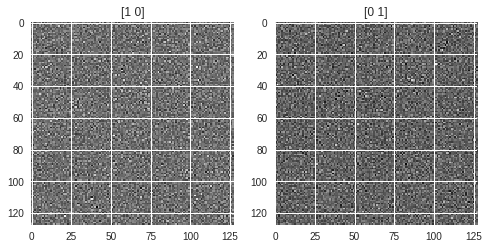

In [7]:
# Why do you name X_val = X and then you use X for training the model?
X,Y = X_val,Y_val

# first index of different labels (shuffled up)
i=np.argwhere((Y_val[:10]==np.array([1,0])).mean(1) == 1).flatten()[0]
j=np.argwhere((Y_val[:10]==np.array([0,1])).mean(1) == 1).flatten()[0]

fig = plt.figure()
a = fig.add_subplot(121)
a.set_title('%s' % Y[i])
plt.imshow(X[i,:,:,0],cmap='gray')

a = fig.add_subplot(122)
a.set_title('%s' % Y[j])
plt.imshow(X[j,:,:,0],cmap='gray')


# Build model

User can customize number of layers and parameters for building a Deep Learning network

In [0]:
# Definition of paramaters depending of the number of layers

blocks = 5 # Each block has 5 layers = 2 Conv2D + 1 Activation + 1 Normalization + 1 Pooling


""" k1_size = Kernel size of the first Conv2D layer
    K2_size = Kernel size of the second Conv2D layer
    pool1 = max pooling size
"""


#inputl_kernel = [k1_size,k2_size]
"""Represents the kernel size of the first layer of the network or call input layer"""
inputl_kernel = [15,15]

#inputl_node =  [node1_number, node2_number]
"""Represents the number of node that each CONV2D layer has in the first layer"""
inputl_node = [8,8]

#hiddenl_kernel = [k3_size, k4_size, k5_size,k6_size,...] # Depends on the number of layers
"""Represents the kernel size of the hidden layers of the network"""
hiddenl_kernel = [7,7,3,3]

# hiddenl_node = [node3_number, node4_number, node5_number, node6_number,...] # Depends on the number of layers
"""Represents the number of node that each CONV2D layer has in the hidden layers"""
hiddenl_node = [8,16,32,32]

# pooling_size = [pool1_size, pool2_size, pool3_size, ...] # Depends on the number of layers
"""Represents the size of pooling layer in the input and hidden layer"""
pooling_size = [7,5,3]


# Penultimate Block
# av_pool = [node1_number, node2_number, k1_size, k2_size, av_pool_size]
#average_pool= [64, 64, 3, 3, 4]
n1_ave_pool = 64
n2_ave_pool = 64
k1_ave_pool = 3
k2_ave_pool = 3 
av_pool = 4

# Output Layer = Full connected network
# output_layer = [val_dense, drop]
#output_layer = [512, 0.75]
val_dense = 1024
drop = 0.5


In [9]:
# Define input shape and number of classes

input_shape=X.shape[1::]
n_classes = 2

# Call function build_network

model = build_network (blocks,input_shape, inputl_node,inputl_kernel,hiddenl_node,
                     hiddenl_kernel, pooling_size, n1_ave_pool, n2_ave_pool, 
                     k1_ave_pool, k2_ave_pool, av_pool, val_dense, drop, n_classes)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
# Print model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 8)       1808      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 8)       14408     
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 8)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 8)       32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 8)         3144      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 16)        6288      
__________

# Train model

In [0]:
batch_size = 25
steps_per_epoch = np.floor(df.shape[0] / batch_size) # 110 for 11k particles

In [0]:
# Compile Model
# Select optimizer, loss,and metrics
model.compile(optimizer = SGD() , loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [13]:
# model.fit_generator trains the model on data generated batch-by-batch by a Python generator (or an instance of Sequence).

for _ in range(1):
    model.fit_generator(fit_generator_helper.image_loader(df,batch_size=batch_size,nx=nx,ny=ny,crop_n=128),
                    steps_per_epoch=steps_per_epoch, # steps_per_epoch is number of batches per epoch
                    epochs=40,
                   )
    scores = model.evaluate(X_val, Y_val)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
72/72 [==============================] - 170s 2s/step - loss: 0.9394 - categorical_accuracy: 0.5039
Epoch 2/40
72/72 [==============================] - 7s 101ms/step - loss: 0.7810 - categorical_accuracy: 0.5056
Epoch 3/40
72/72 [==============================] - 7s 102ms/step - loss: 0.7183 - categorical_accuracy: 0.5228
Epoch 4/40
72/72 [==============================] - 7s 102ms/step - loss: 0.7204 - categorical_accuracy: 0.5489
Epoch 5/40
72/72 [==============================] - 7s 102ms/step - loss: 0.6781 - categorical_accuracy: 0.5961
Epoch 6/40
72/72 [==============================] - 7s 99ms/step - loss: 0.6656 - categorical_accuracy: 0.5889
Epoch 7/40
72/72 [==============================] - 7s 98ms/step - loss: 0.6476 - categorical_accuracy: 0.6228
Epoch 8/40
72/72 [==============================] - 7s 100ms/step - loss: 0.6306 - categorical_accuracy: 0.6328
Epoch 9/40
72/72 [==============================] - 7s 100m

# Performance Graphs

**ROC Curves and AUc**

In [0]:
from sklearn.metrics import roc_curve
# Making prediction using the model trained above and the validation data set

y_pred = model.predict(X_val)

fpr_model1, tpr_model1, thresholds_model1 = roc_curve(Y_val.argmax(axis=1), y_pred.argmax(axis=1))


In [15]:
from sklearn.metrics import auc
auc_model1 = auc(fpr_model1, tpr_model1)
print('AUC: %.3f' % auc_model1)

AUC: 0.765


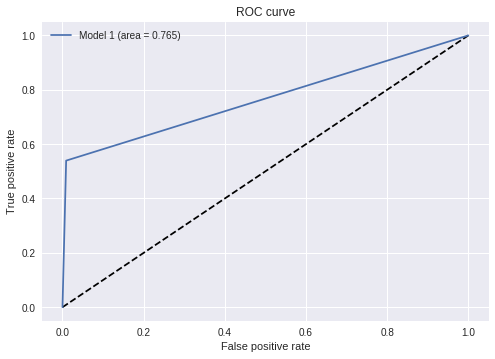

In [16]:
# Plot ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_model1, tpr_model1, label='Model 1 (area = {:.3f})'.format(auc_model1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

**Precision - Recall Curves**

In [0]:
# Calculate precision-recall curve

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score


precision, recall, thresholds = precision_recall_curve(Y_val.argmax(axis=1), y_pred.argmax(axis=1))

In [18]:
# Calculate F1 score
f1 = f1_score(Y_val.argmax(axis=1), y_pred.argmax(axis=1))

# Calculate precision-recall AUC
auc = auc(recall, precision)

# Calculate average precision score
ap = average_precision_score(Y_val.argmax(axis=1), y_pred.argmax(axis=1))
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))

f1=0.696 auc=0.862 ap=0.733


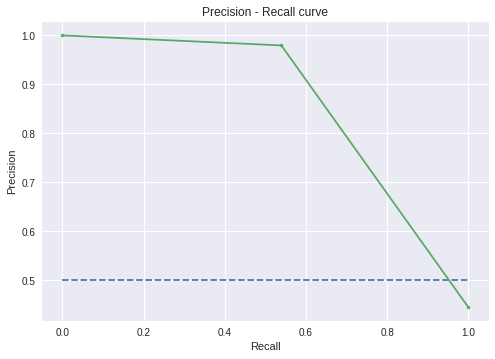

In [19]:
# Plot Curves
# Plot no skill
plt.figure(2)
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# Plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')
# Show the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall curve')
#plt.legend(loc='best')
plt.show()

**Accuracy and Loss vs Epochs**

In [20]:
history = model.fit_generator(fit_generator_helper.image_loader(df,batch_size=batch_size,nx=nx,ny=ny,crop_n=128),
                    steps_per_epoch=steps_per_epoch, # steps_per_epoch is number of batches per epoch
                    epochs=26, validation_data=(X_val,Y_val), verbose=1)


Epoch 1/26
72/72 [==============================] - 8s 105ms/step - loss: 0.1691 - categorical_accuracy: 0.9356 - val_loss: 5.5360 - val_categorical_accuracy: 0.5800
Epoch 2/26
72/72 [==============================] - 7s 102ms/step - loss: 0.1531 - categorical_accuracy: 0.9522 - val_loss: 5.8872 - val_categorical_accuracy: 0.5750
Epoch 3/26
72/72 [==============================] - 8s 105ms/step - loss: 0.1451 - categorical_accuracy: 0.9461 - val_loss: 4.4131 - val_categorical_accuracy: 0.6100
Epoch 4/26
72/72 [==============================] - 8s 105ms/step - loss: 0.1553 - categorical_accuracy: 0.9383 - val_loss: 6.4660 - val_categorical_accuracy: 0.5600
Epoch 5/26
72/72 [==============================] - 8s 104ms/step - loss: 0.1497 - categorical_accuracy: 0.9461 - val_loss: 6.8236 - val_categorical_accuracy: 0.5550
Epoch 6/26
72/72 [==============================] - 7s 104ms/step - loss: 0.1580 - categorical_accuracy: 0.9528 - val_loss: 3.8747 - val_categorical_accuracy: 0.6200
Epoc

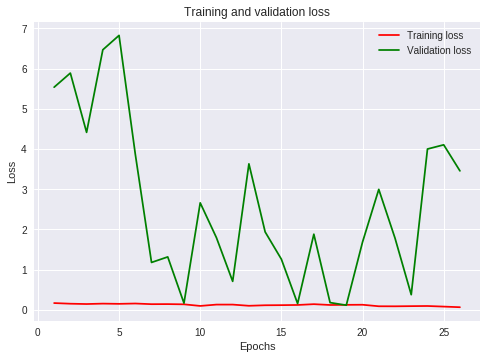

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


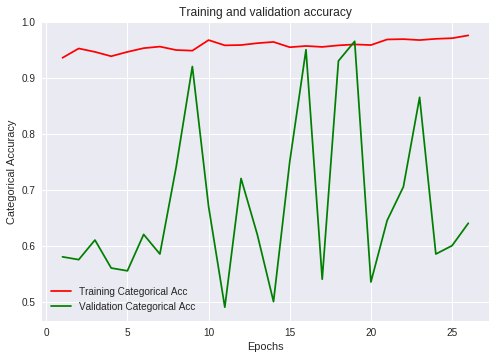

In [22]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
plt.plot(epochs, acc, color='red', label='Training Categorical Acc')
plt.plot(epochs, val_acc, color='green', label='Validation Categorical Acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()